# Final Report (Group #36)

In [7]:
# Load the packages and set the seed

library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(GGally)
library(gtable)
library(grid)
library(gridExtra)

options(repr.matrix.max.rows = 6)
set.seed(2022) 

## _INTRO:_


**Our Predictive Question :  Can age, resting blood pressure, cholestoral levels, and maximum heart rate achieved accurately predict the diagnosis of heart disease?**

Heart disease is an increasingly prevalent condition affecting a multitude of different people globally. Heart disease refers to a multitude of different heart conditions such as coronary artery disease and cardiomyopathy ("About Heart Disease", 2022). These debilitating conditions contribute annually to 1 in 4 American deaths every year (2022), making prompt diagnosis and treatment of these conditions of grave importance. Though the onset of these conditions vary, generally there are certain risk factors which can contribute to a heart disease diagnosis. These factors can include high blood pressure, physical inactivity, and high blood cholesterol (2022). Understanding these risk factors and finding individuals who may have them could lead to a more prompt diagnosis of these diseases and thus more effective treatment.

Our project aims to investigate if age, resting blood pressure, cholesterol levels and maximum heart rate of an individual can be predictors of a heart disease diagnosis. In understanding the predictive ability of these four variables more reliable diagnosis options can be explored to help patients before the onset of debilitating heart disease. 

The data set we will use to explore this predictive problem is a compiled heart disease data set from Kaggle.com. This data set contains information on multiple onset heart disease risk factors of individuals admitted to the hospital for acute chest pain with patient data from 4 different global locailites spanning from 1988 onwards. This data set includes information about the age, sex, cheat pain type (from 0-4), the resting blood pressure, serum cholestoral level in the blood, the fasting blood sugar, the maximum heart rate achieved, the presence of exercise induced angina, the number of major vessels (from 0-3). and the diagnosis of the blood disorder thalassemia with 0 as normal, 1 as fixed defect and 2 as reversible defect. Additionally, there is data about results of electrocardiogram tests including the resting electrocardiographic results (values 0-2), the ST depression value and the slope of the ST segment. 

Lastly, there is data on the presence of heart disease in the patient with ...
 * 0 indicating no heart disease 
 * 1 indicating the presence of heart disease. 


## _Methods/Results --> Analysis:_ 

We will be using the KNN Classification method to predict the presence of heart disease

***1) Loading our data:***
- Below, we first load our dataset through a URL since the required packages are loaded above. We also set the seed (above) to have consistent randomness. We do adjustments to the dataset, such as converting our categorical variable to a factor and removing the repeated observations with the unique() function. We then select the relevant predictors instead of the entire dataset for our analysis which we stated in our proposal:

    * We had visualized the training data using the ggpairs() function to plot the columns against each other that can effectively show which columns we could use as our predictors. We chose the 4 selected below as predictors (age, trestbps, chol, thalach, target) based on the scatter plots which showed the points in sorts of groups which indicates that they have a relation.


In [3]:
url <- "https://raw.githubusercontent.com/sadia-kd/DSCI-Project/main/heart.csv"

heart_disease <- read_csv(url) %>%
    mutate(target = as_factor(target)) %>%
    unique() %>%
    select(age, trestbps, chol, thalach, target)

heart_disease

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  target = col_double()
)



age,trestbps,chol,thalach,target
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,125,212,168,0
53,140,203,155,0
70,145,174,125,0
⋮,⋮,⋮,⋮,⋮
52,128,255,161,0
59,160,273,125,0
54,120,188,113,0


### Exploring The Data

***2) Split the dataset into training/testing data sets***

- Before visualizing our data, we split it into the training/testing sets using the initial_split() function so that we can perform a summary of the training data set that is relevant for exploratory data analysis related to our planned analysis 

    * We also split our training set to have a proportion of 75% of the dataset so that we can train our model with the training set, and use the remaining 25% to test our model and evaluate it.


In [4]:
# spliting the data into training/testing sets

heart_disease_split <- initial_split(heart_disease, prop = 0.75, strata = target)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split) 


***3) Explore the data (exploratory data analysis)***

- Next, the 3 cells below are examples of how we analyzed our data:
1) The first one is a table which shows the number of observations in each class in the training set and the % of each class present which will be identical to the % in the entire dataset. This dataset has about 46% of cases with no heart disease and about 54% with heart disease. This proves that overall, our data is balanced between the 2 classes.

2) The second cell indicates that our data has no missing data

3) Finally, the third cell is a 'summary' to show more information about the dataset, e.g. mean/min/max values for our predictors and again the number of observations for each class for our categorical variable we are predicting ('target' variable in our dataset)

In [5]:
# Summarize the training DATA 

obs <- nrow(heart_disease_train)

data_count <- heart_disease_train %>%
    group_by(target) %>%
    summarize(count = n(), percentage = n()/obs * 100)
data_count

`summarise()` ungrouping output (override with `.groups` argument)



target,count,percentage
<fct>,<int>,<dbl>
0,104,45.81498
1,123,54.18502


In [6]:
sum(is.na(heart_disease_train))

[1] 0

In [7]:
summary(heart_disease_train)

      age          trestbps          chol          thalach      target 
 Min.   :34.0   Min.   : 94.0   Min.   :126.0   Min.   : 71.0   0:104  
 1st Qu.:47.0   1st Qu.:120.0   1st Qu.:212.0   1st Qu.:133.0   1:123  
 Median :56.0   Median :130.0   Median :240.0   Median :152.0          
 Mean   :54.6   Mean   :131.9   Mean   :244.8   Mean   :149.1          
 3rd Qu.:61.0   3rd Qu.:140.0   3rd Qu.:273.5   3rd Qu.:165.0          
 Max.   :76.0   Max.   :192.0   Max.   :417.0   Max.   :195.0          

### Visualization of the data

***4) Visualize the data (before the analysis)***
- Below, we visualize our data, before that, we also separately Scale and Center the DATA here to normalize the data and use this to get more affective plots. There were differences in how each column were measured, therefore, scaling and centering will help with accuracy.

In [8]:
# scale and center + prep and bake to inspect the result of the preprocessing steps 

scaled_heart_disease <- recipe(target  ~ ., data = heart_disease_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    prep() %>%
    bake(heart_disease_train)

scaled_heart_disease

age,trestbps,chol,thalach,target
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.1788826,0.4776845,-0.8727205,0.2608543,0
0.7135645,0.9470973,-0.8727205,0.5279849,0
0.8251204,0.3603312,1.0251411,-1.9207117,0
⋮,⋮,⋮,⋮,⋮
-0.29043846,-0.2264348,0.2117718,0.5279849,0
0.49045277,1.6512166,0.5871731,-1.0747984,0
-0.06732668,-0.6958477,-1.1855549,-1.6090594,0


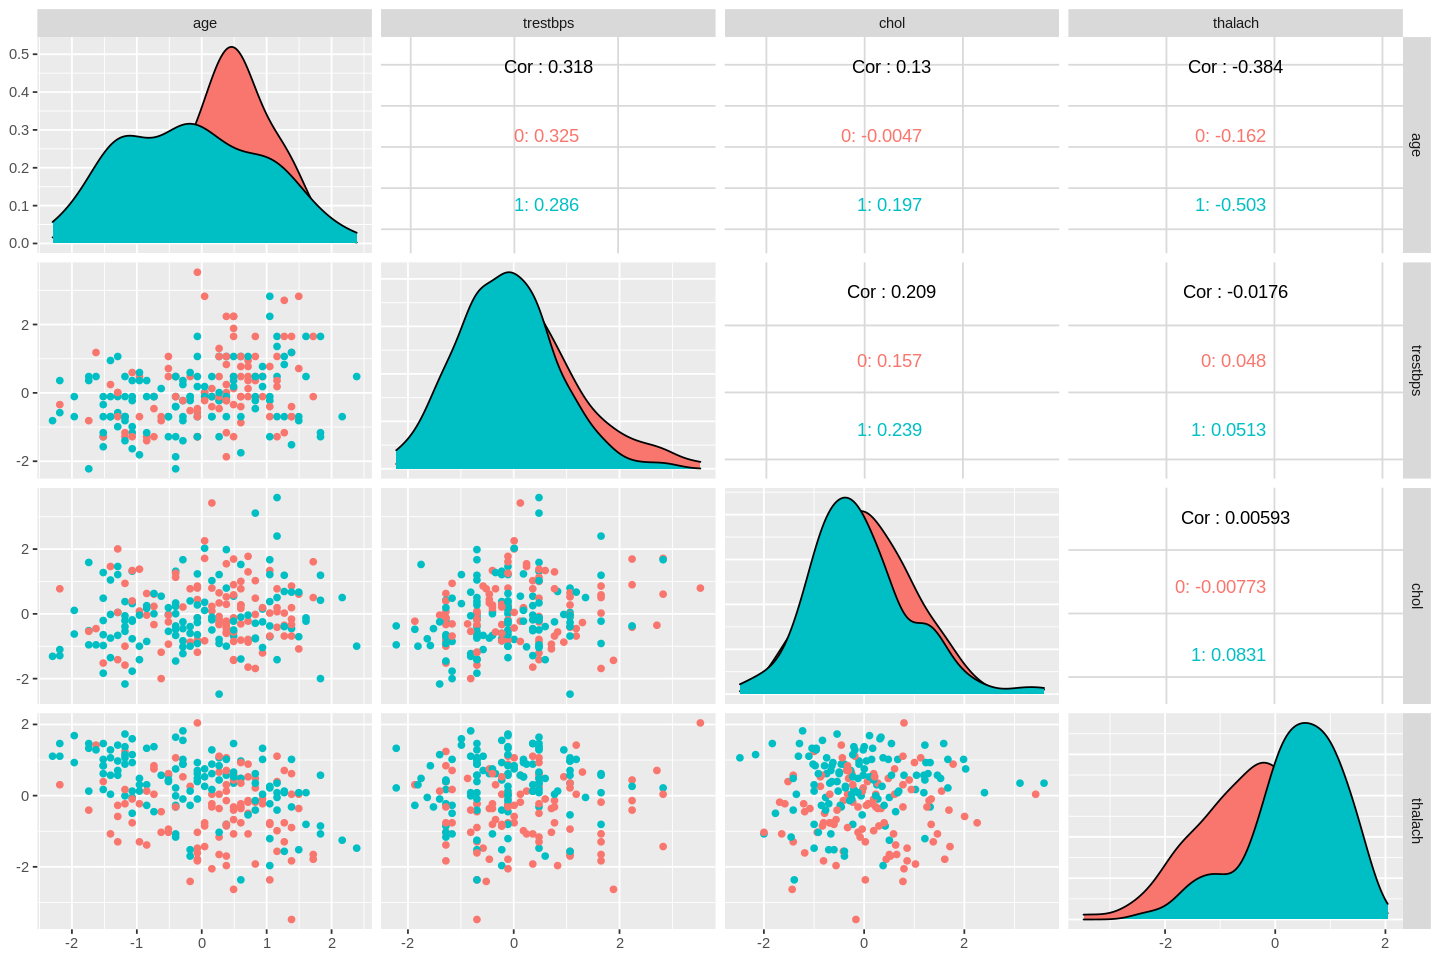

In [9]:
# Plot all appropriate columns against each other, and colour by the target
options(repr.plot.width = 12, repr.plot.height = 8) 

plots <- ggpairs(scaled_heart_disease, mapping = aes(color = target), columns = 1:4)

plots

- The above matrix plot indeed shows that there are distinguished present between the predictors as we colour the plots by "target" which is the columnn that states whether there is heart disease or not

### _Performing the Analsyis_

***5) Tuning our model:***

- To find the best K value, we first tune the model using a 5-fold cross validation method on the training set and then we plot the accuracy vs # of neighbors to illustrate which K value has the highest accuracy

- We have already selected the specific columns we will need in the beginning when loading the data
#### Begin with creating the model (tuning it)

In [20]:
# Set the seed. Don't remove this!
set.seed(2022) 

# Preprocessing the data 

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
        set_engine("kknn") %>%
        set_mode("classification")

heart_recipe <- recipe(target ~. , data = heart_disease_train) %>%
        step_scale(all_predictors()) %>%
        step_center(all_predictors())

- Next,  we create the 5-fold cross-validation on the training set
- AND we also create a data frame with a neighbors variable that contains the sequence of values of K to try containing values from 1 to 100 (stepping by 5)

In [18]:
# Set the seed. Don't remove this!
set.seed(2022)

# 5-fold cross-validation
vfold <- vfold_cv(heart_disease_train, v = 5, strata = target)

# tibble of k-vals
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

- Now, we put it all together in a workflow, and use the collect_metrics() function to obtain and in a table format to view the results produced by tuning 

In [13]:
# Set the seed. Don't remove this!
set.seed(2022)

# Putting it in a workflow

heart_disease_workflow <- workflow() %>%
        add_recipe(heart_recipe) %>%
        add_model(heart_spec) %>%
        tune_grid(resamples = vfold, grid = k_vals) %>%
        collect_metrics()
heart_disease_workflow

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6082345,5,0.01695131,Model01
1,roc_auc,binary,0.6052857,5,0.01751160,Model01
6,accuracy,binary,0.6385727,5,0.01221243,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
91,roc_auc,binary,0.7310774,5,0.01900421,Model19
96,accuracy,binary,0.6438076,5,0.02306173,Model20
96,roc_auc,binary,0.7336349,5,0.02147386,Model20


- Now we extract "accuracy", from the .metric column because the rest observations are not necessary for our analysis in creating the model. 
- Then we plot the the Accuracy VS K-values to determine which number of neighbors is best to use in our knn-classification

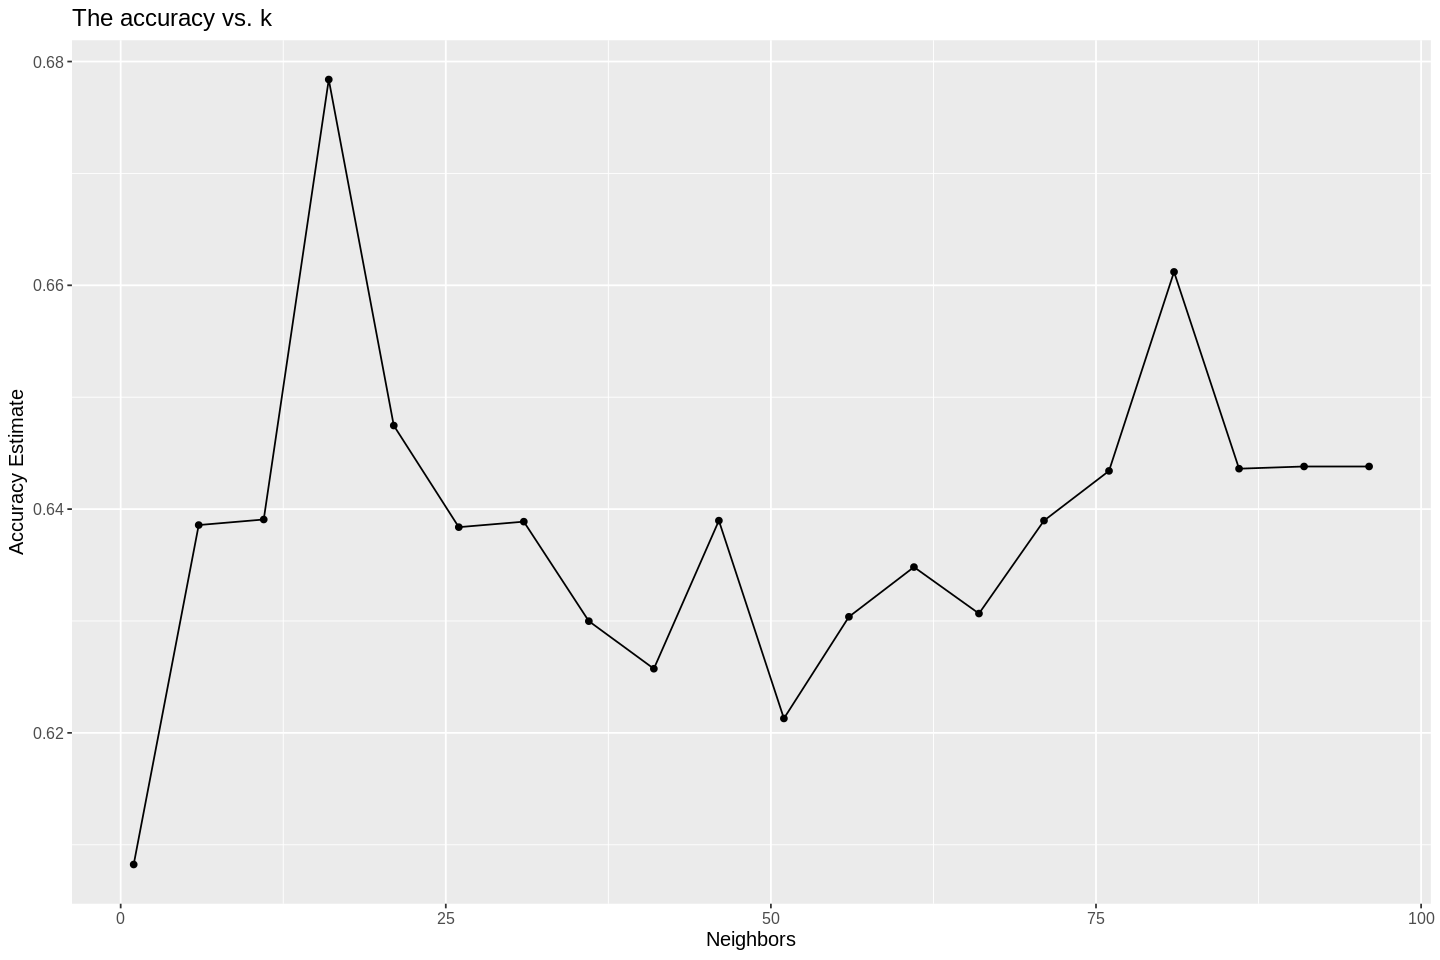

In [21]:
# Accuracy VS K-values

accuracies <- heart_disease_workflow %>% 
        filter(.metric == "accuracy") 

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Neighbors", y = "Accuracy Estimate") +
        theme(text = element_text(size = 12)) +
        ggtitle("The accuracy vs. k")

accuracy_vs_k

- It might be difficult reading the # of Neighbors from the line plot above, that is why we do the following below to extract the actual k-value.

In [22]:
# Find the # Neighbors through data

k_accurate <- heart_disease_workflow %>% 
        filter(.metric == "accuracy") %>%
        arrange(mean) %>%
        tail(1) %>%
        pull(neighbors)

k_accurate

[1] 16

***6) Re-train our model with the K value obtained and perform K-nearest neighbor classification:***

- We will now use the highest K found to re-train our model and then test our model by predicting the testing set

### **The k-value which we found that provides the highest accurate model is 16, we will now use this and re-do our knn classification to predict our test set**

#### Build Our Final Model

In [23]:
# Set the seed. Don't remove this!
set.seed(2022)

# use neighbors = 16
# create new model but use the same recipe as nothing changes there

best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 16) %>%
        set_engine("kknn") %>%
        set_mode("classification")

Knn_fit <- workflow() %>%
        add_recipe(heart_recipe) %>%
        add_model(best_spec)%>%
        fit(data = heart_disease_train)

Knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~16, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3436123
Best kernel: rectangular
Best k: 16

#### Predit the heart_disease_test set now
- We can now use the predict() function to predict our test set, and then view how accurately our model predicts the test set by adding the predicted column, and filtering for "accuracy"

In [24]:
data_predicted <- predict(Knn_fit, heart_disease_test) %>%
        bind_cols(heart_disease_test) %>%
        metrics(truth = target, estimate = .pred_class) %>%
        filter(.metric == "accuracy")

data_predicted

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.72


***7) Result Analysis:***

### Evaluate accuracy for all cases with their best K ( Combination of each two variables)

***8) Review our model/goal/report***

## Final Discussion 

In [25]:
# Jessica and Quynh

### References:

These were the following references that we used to help our analysis by understanding the dataset we are working with about Heart Disease

- Lapp, D. (2019). Heart Disease Dataset (Kaggle.com) [Data set].*

- About Heart Disease. (2022). Retrieved 25 March 2022, from https://www.cdc.gov/heartdisease/about.htm*
